## Quora Question Pair Similarity 

### Objective: To predict which of the provided pairs of questions contain two questions with the same meaning

#### Data Overview
1. id - the id of a training set question pair
2. qid1, qid2 - unique ids of each question (only available in train.csv)
3. question1, question2 - the full text of each question
4. is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise

#### Evaluation Metric 
1. Log loss
2. Confusion Matrix

In [65]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
warnings.filterwarnings("ignore")

In [66]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import nltk

from tqdm import tqdm
import re
from bs4 import BeautifulSoup

In [67]:
from fuzzywuzzy import fuzz

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as sciplot

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

In [70]:
data  = pd.read_csv('../input/train.csv')

In [71]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [72]:
data.info() # question2 has 2 null features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## Distribution of data points among output classes

In [73]:
data.groupby('is_duplicate')['id'].count()

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

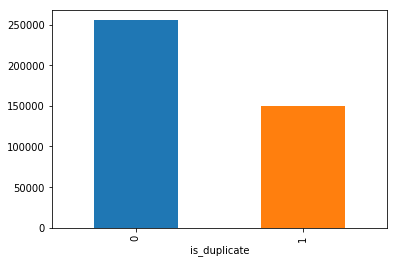

In [74]:
data.groupby('is_duplicate')['id'].count().plot.bar()


In [75]:
print('~> Question pairs that are duplicate: {}%'.format( round(data['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs that are not duplicate: {}%'.format(100 - round(data['is_duplicate'].mean()*100, 2)))

~> Question pairs that are duplicate: 36.92%

~> Question pairs that are not duplicate: 63.08%


## Number of unique questions

In [76]:
qs_list = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
print('Number of unique questions: {}'.format(len(np.unique(qs_list))))

Number of unique questions: 537933


In [77]:
#Number of questions that are repeated more than one time
a = np.sum((qs_list.value_counts() >1))
print("Number of times unique questions are repeated more than one time: {}".format(a))

Number of times unique questions are repeated more than one time: 111780


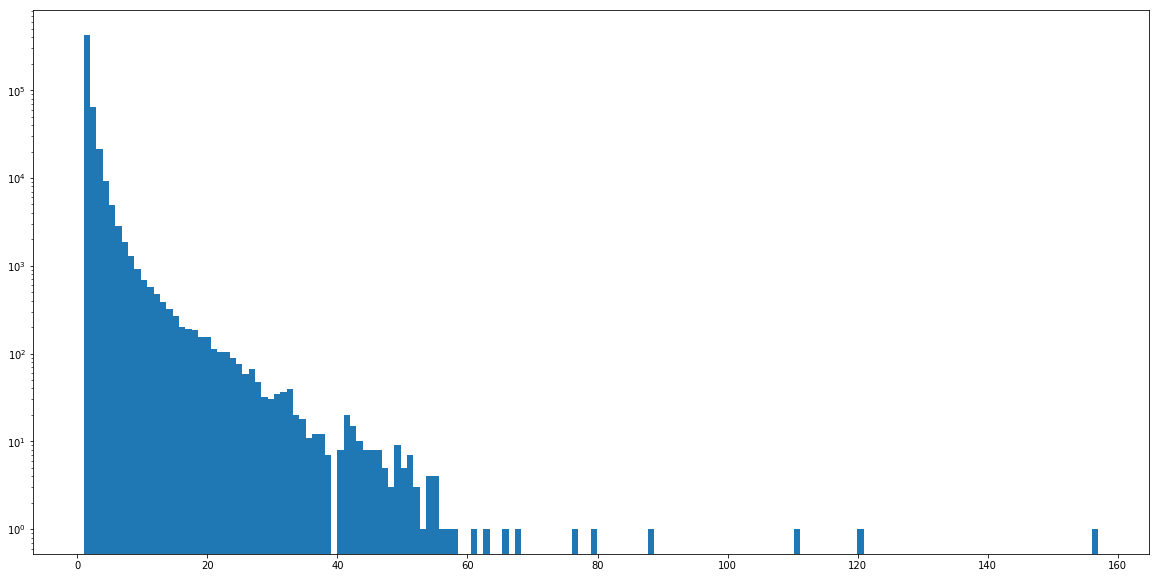

In [78]:
## Number of occurances of each questions
plt.figure(figsize=(20, 10))
#bins_edge = [i for i in range(0,160,10)]
plt.hist(qs_list.value_counts() , bins = 160 )
plt.yscale('log', nonposy='clip')
plt.show()

## Checking duplicate pairs

In [79]:
duplicate_pair = data[['qid1' , 'qid2']].groupby(['qid1' , 'qid2']).count().shape[0]
print('Number of duplicate pair: {}'.format(data.shape[0] - duplicate_pair))

Number of duplicate pair: 0


## Checking for null values

In [80]:
# checking rows in question2 which has null values
data[data['question2'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [81]:
# checking if there any question exist with id 174364
data[data['qid2']==174364]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [82]:
# filling null value with empty string
data.fillna(' ' , inplace = True)
data[data['question2'].isnull()] # no NaN left

,id,qid1,qid2,question1,question2,is_duplicate


## Text Preprocessing

1. Removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no
adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Stemming

In [83]:
nltk.download('stopwords')
stop = stopwords.words('english') # set of english stopwords
#stop.remove("not")
print(stop)
sno = nltk.stem.SnowballStemmer('english')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both

In [84]:
def text_preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x , 'lxml')
        x = example1.get_text()
               
    
    return x
    

In [85]:
data['cleanedText_qs1'] = data['question1'].apply(text_preprocess)

In [86]:
data['cleanedText_qs2'] = data['question2'].apply(text_preprocess)

In [87]:
data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cleanedText_qs1,cleanedText_qs2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...


### Basic Feature Extraction 

In [88]:
data['freq_q1'] = data.groupby('qid1')['qid1'].transform('count')
data['freq_q2'] = data.groupby('qid2')['qid2'].transform('count')
data['q1_len'] = data['cleanedText_qs1'].str.len()
data['q2_len'] = data['cleanedText_qs2'].str.len()
data['q1_n_words '] = data['cleanedText_qs1'].apply(lambda x : len(x.split()))
data['q2_n_words'] =data['cleanedText_qs2'].apply(lambda x:len(x.split()))

def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['cleanedText_qs1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['cleanedText_qs2'].split(" ")))    
        return 1.0 * len(w1 & w2)
data['word_Common'] = data.apply(normalized_word_Common, axis=1)


def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['cleanedText_qs1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['cleanedText_qs2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
data['word_Total'] = data.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['cleanedText_qs1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['cleanedText_qs2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
   
data['word_share'] = data.apply(normalized_word_share, axis=1)

data['freq_q1+q2'] = data['freq_q1']+data['freq_q2']
data['freq_q1-q2'] = abs(data['freq_q1']-data['freq_q2'])




In [89]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,cleanedText_qs1,cleanedText_qs2,freq_q1,freq_q2,q1_len,q2_len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,1,1,66,57,14,12,12.0,25.0,0.480000,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,4,1,51,88,10,15,8.0,26.0,0.307692,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,1,1,73,59,14,10,5.0,26.0,0.192308,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,1,1,50,65,11,13,1.0,22.0,0.045455,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,3,1,76,39,13,7,5.0,22.0,0.227273,4,2


' **Advanced Feature Extraction**

In [90]:
# tokens
q1_tokens = data['cleanedText_qs1'].str.split()
q2_tokens = data['cleanedText_qs2'].str.split()

In [91]:
q1_words = [list(set([ w for w in l if w not in stop]))for l in q1_tokens]
q2_words = [list(set([ w for w in l if w not in stop]))for l in q2_tokens]

q1_stops = [list(set([ w for w in l if w  in stop]))for l in q1_tokens]
q2_stops = [list(set([ w for w in l if w  in stop]))for l in q2_tokens]


In [92]:
def common_count(q1 , q2):
    count = []
    for i in range(len(q1_words)):
        q1_set = set(q1[i])
        q2_set = set(q2[i])
        count.append(len(q1_set.intersection(q2_set)))
    
    return count

In [93]:
common_word_count = common_count(q1_words ,q2_words )
common_stop_count = common_count(q1_stops ,q2_stops )
common_token_count = common_count(q1_tokens ,q2_tokens )

In [94]:
def count_min(count , q1 , q2):
    l = []
    for i in range(len(data)):
        a = min(len(q1[i]), len(q2[i]))
        if a!=0:
            l.append(count[i]/a)
        else:
            l.append(0.)
    return l

In [95]:
def count_max(count , q1 , q2):
    l = []
    for i in range(len(data)):
        a = max(len(q1[i]), len(q2[i]))
        if a!=0:
            l.append(count[i]/a)
        else:
            l.append(0.)
    return l

In [96]:
cwc_min = count_min(common_word_count , q1_words , q2_words)
cwc_max = count_max(common_word_count , q1_words , q2_words)

csc_min = count_min(common_stop_count , q1_stops , q2_stops)
csc_max = count_max(common_stop_count , q1_stops , q2_stops)

ctc_min = count_min(common_token_count , q1_tokens , q2_tokens)
ctc_max = count_max(common_token_count , q1_tokens , q2_tokens)

In [97]:

def diff(q1 , q2):
    l=[]
    for i in range(len(data)):
        l.append(abs(len(q1[i]) - len(q2)))
    return l
    
def avg(q1,q2):
    l = []
    for i in range(len(data)):
        l.append((len(q1[i]) +len(q2))/2)
    return l


#lst_word_eq = lst_wrd_eq(q1_tokens , q2_tokens)
#fst_word_eq = fst_word_eq(q1_tokens , q2_tokens)
abs_len_diff = diff(q1_tokens , q2_tokens)
mean_len = avg(q1_tokens , q2_tokens)


In [98]:
data['cwc_min'] = cwc_min
data['cwc_max'] = cwc_max
data['csc_min'] = csc_min
data['csc_max'] = csc_max
data['ctc_min'] = ctc_min
data['ctc_max'] = ctc_max
data['abs_len_diff'] = abs_len_diff
data['mean_len'] = mean_len

In [99]:
data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cleanedText_qs1,cleanedText_qs2,freq_q1,freq_q2,q1_len,q2_len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,abs_len_diff,mean_len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,1,1,66,57,14,12,12.0,25.0,0.480000,2,0,1.0,0.833333,1.00,1.0,0.916667,0.785714,404276,202152.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,4,1,51,88,10,15,8.0,26.0,0.307692,5,3,0.8,0.400000,0.75,0.6,0.700000,0.466667,404280,202150.0


In [100]:
def lst_wrd_eq(x):
    if ((x[0] is not '') and (x[1] is not '')):
        q1 = x[0].split()[-1]
        q2 = x[1].split()[-1]
    else:
        return 0
    return int(q1==q2)

def fst_wrd_eq(x):
    if ((x[0] is not '') and (x[1] is not '')):
        q1 = x[0].split()[0]
        q2 = x[1].split()[0]
    else:
        return 0
    return int(q1==q2)

In [101]:
data['last_word_eq'] = data[['cleanedText_qs1', 'cleanedText_qs2']].apply(lst_wrd_eq , axis = 1)

In [102]:
data['first_word_eq'] = data[['cleanedText_qs1', 'cleanedText_qs2']].apply(fst_wrd_eq , axis = 1)

In [103]:
## Ref:  https://stackoverflow.com/questions/18715688/find-common-substring-between-two-strings

def longestSubstring(x):
    string1 = x[0]
    string2 = x[1]
    
    answer = ""
    len1, len2 = len(string1), len(string2)
    for i in range(len1):
        match = ""
        for j in range(len2):
            if (i + j < len1 and string1[i + j] == string2[j]):
                match += string2[j]
            else:
                if (len(match) > len(answer)): answer = match
                match = ""
    
    if len(answer) == 0:
        return 0
    else:
        return len(answer) / (min(len(string1), len(string2)) + 1)



In [104]:
data["token_set_ratio"]       = data.apply(lambda x: fuzz.token_set_ratio(x["cleanedText_qs1"], x["cleanedText_qs2"]), axis=1)
# The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
# then joining them back into a string We then compare the transformed strings with a simple ratio().
data["token_sort_ratio"]      = data.apply(lambda x: fuzz.token_sort_ratio(x["cleanedText_qs1"], x["cleanedText_qs2"]), axis=1)
data["fuzz_ratio"]            = data.apply(lambda x: fuzz.QRatio(x["cleanedText_qs1"], x["cleanedText_qs2"]), axis=1)
data["fuzz_partial_ratio"]    = data.apply(lambda x: fuzz.partial_ratio(x["cleanedText_qs1"], x["cleanedText_qs2"]), axis=1)

In [105]:
data["longest_substr_ratio"]  = data[['cleanedText_qs1', 'cleanedText_qs2']].apply(longestSubstring, axis=1)

In [106]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,cleanedText_qs1,cleanedText_qs2,freq_q1,freq_q2,q1_len,q2_len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,abs_len_diff,mean_len,last_word_eq,first_word_eq,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,1,1,66,57,14,12,12.0,25.0,0.480000,2,0,1.0,0.833333,1.00,1.000000,0.916667,0.785714,404276,202152.0,0,1,100,93,93,100,0.103448
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,4,1,51,88,10,15,8.0,26.0,0.307692,5,3,0.8,0.400000,0.75,0.600000,0.700000,0.466667,404280,202150.0,0,1,86,63,66,75,0.096154
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,1,1,73,59,14,10,5.0,26.0,0.192308,2,0,0.4,0.333333,0.40,0.250000,0.400000,0.285714,404276,202152.0,0,1,66,66,54,54,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,1,1,50,65,11,13,1.0,22.0,0.045455,2,0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,404279,202150.5,0,0,36,36,35,40,0.039216
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,3,1,76,39,13,7,5.0,22.0,0.227273,4,2,0.4,0.200000,1.00,0.666667,0.571429,0.307692,404277,202151.5,0,1,67,47,46,56,0.150000


### Train and Test Split

In [107]:
X_train , X_test , Y_train , Y_test = train_test_split(data , data['is_duplicate'] , test_size = 0.3)

In [108]:
print("Size of train set: {}".format(len(X_train)))
print('Size of test set: {}'.format((len(X_test))))

Size of train set: 283003
Size of test set: 121287


## Checking distribution of class labels in train and test set

In [109]:
# distribution in of class labels in train
train_len = len(Y_train)
print('{} %  are not Duplicates in train:'.format(round( Y_train.value_counts()[0] / train_len   , 4)*100 ))
print('{} %  are Duplicates in train:'.format(round( Y_train.value_counts()[1] / train_len, 4  )*100 ))

63.129999999999995 %  are not Duplicates in train:
36.870000000000005 %  are Duplicates in train:


In [110]:
# distribution of class labels in test
test_len = len(Y_test)
print('{} %  are not Duplicates in train:'.format(round( Y_test.value_counts()[0] / test_len   , 4)*100 ))
print('{} %  are Duplicates in train:'.format(round( Y_test.value_counts()[1] / test_len, 4  )*100 ))

62.970000000000006 %  are not Duplicates in train:
37.03 %  are Duplicates in train:


In [111]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Building a random model (Finding worst-case log-loss)


Log loss on Test Data using Random Model 0.8851992458604895


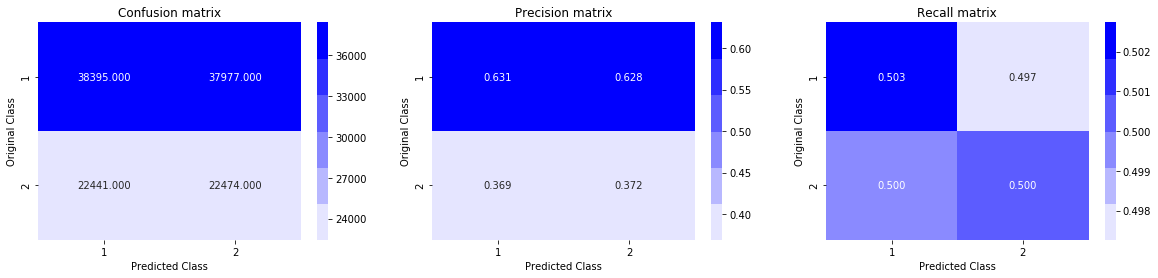

In [112]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log loss on Test Data using Random Model",log_loss(Y_test, predicted_y, eps=1e-15))
predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(Y_test, predicted_y)

## Logistic Regression

In [113]:
X_train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,cleanedText_qs1,cleanedText_qs2,freq_q1,freq_q2,q1_len,q2_len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,abs_len_diff,mean_len,last_word_eq,first_word_eq,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
101124,101124,54621,167587,What are the contributions of Abdul Kalam as a...,What was it like to work with Dr. APJ Abdul Ka...,0,what are the contributions of abdul kalam as a...,what was it like to work with dr apj abdul ka...,2,1,57,50,10,11,4.0,23.0,0.173913,3,1,0.5,0.333333,0.2,0.166667,0.3,0.272727,404280,202150.0,0,1,60,54,51,56,0.098039


In [114]:
questions_train = X_train['cleanedText_qs1'] + X_train['cleanedText_qs2']
questions_test = X_test['cleanedText_qs1'] + X_test['cleanedText_qs2']

In [115]:
features_train  = X_train.iloc[: ,8: ]
features_test =  X_test.iloc[:  , 8:]

In [116]:
tf_idf_vect = TfidfVectorizer()
tf_idf_X_train_matrix = tf_idf_vect.fit_transform(questions_train.values)
print(tf_idf_X_train_matrix.shape)
tf_idf_X_test_matrix = tf_idf_vect.transform(questions_test.values)
print(tf_idf_X_test_matrix.shape)

(283003, 74512)
(121287, 74512)


In [117]:
tfidf_X_train_matrix = hstack((tf_idf_X_train_matrix,np.array(features_train)[:,:]))
tfidf_X_test_matrix = hstack((tf_idf_X_test_matrix,np.array(features_test)[:,:]))

In [118]:
def std_data(matrix):
    scaler = StandardScaler(with_mean=False)
    scaler.fit(matrix)
    return scaler.transform(matrix)

In [119]:
tfidf_X_train_matrix = std_data(tfidf_X_train_matrix)
tfidf_X_test_matrix = std_data(tfidf_X_test_matrix)

For values of alpha =  1e-05 The log loss is: 0.6591312599903806
For values of alpha =  0.0001 The log loss is: 0.6591312599903806
For values of alpha =  0.001 The log loss is: 0.6591312599903806
For values of alpha =  0.01 The log loss is: 0.6591312599903806
For values of alpha =  0.1 The log loss is: 0.6591312599903806
For values of alpha =  1 The log loss is: 0.6591312599903806
For values of alpha =  10 The log loss is: 2.6147859664848117


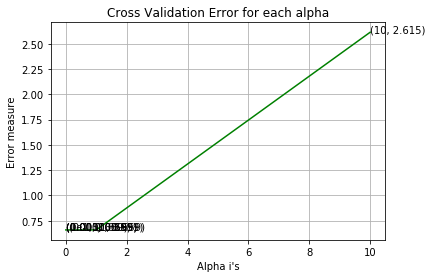

For values of best alpha =  1e-05 The train log loss is: 0.6582692813855
For values of best alpha =  1e-05 The test log loss is: 0.6591312599903806
Total number of data points : 121287


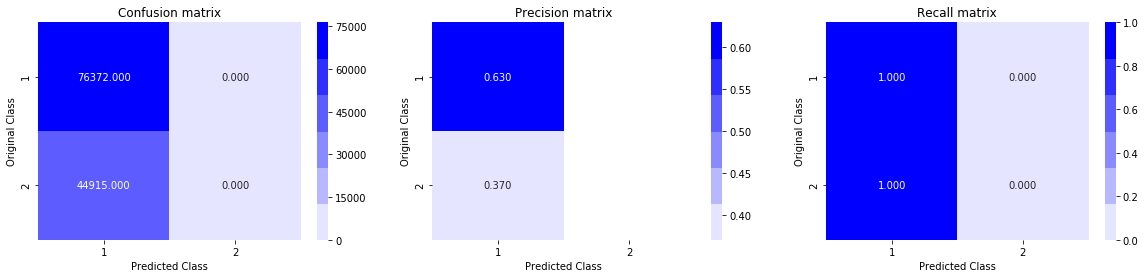

In [120]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(tfidf_X_train_matrix, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_X_train_matrix, Y_train)
    predict_y = sig_clf.predict_proba(tfidf_X_test_matrix)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(tfidf_X_train_matrix, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_X_train_matrix, Y_train)

predict_y = sig_clf.predict_proba(tfidf_X_train_matrix)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_X_test_matrix)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## Linear SVM

For values of alpha =  1e-05 The log loss is: 0.6591312599903806
For values of alpha =  0.0001 The log loss is: 0.501434436847619
For values of alpha =  0.001 The log loss is: 0.5190846644776389
For values of alpha =  0.01 The log loss is: 0.5197109053862681
For values of alpha =  0.1 The log loss is: 0.6478672969244209
For values of alpha =  1 The log loss is: 0.659049464482632
For values of alpha =  10 The log loss is: 0.6591312599903806


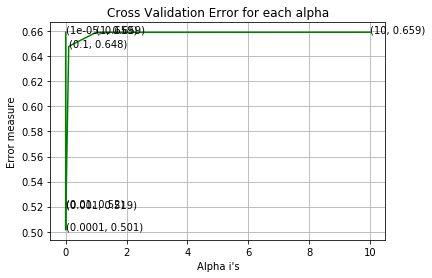

For values of best alpha =  0.0001 The train log loss is: 0.4887825721082295
For values of best alpha =  0.0001 The test log loss is: 0.501434436847619
Total number of data points : 121287


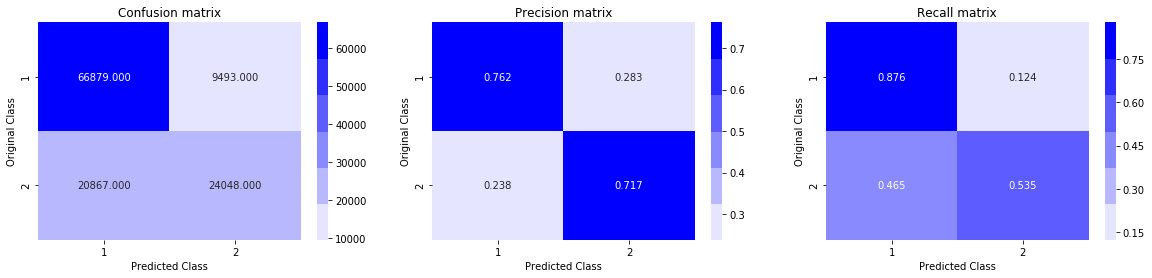

In [121]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(tfidf_X_train_matrix, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_X_train_matrix, Y_train)
    predict_y = sig_clf.predict_proba(tfidf_X_test_matrix)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(tfidf_X_train_matrix, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_X_train_matrix, Y_train)

predict_y = sig_clf.predict_proba(tfidf_X_train_matrix)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_X_test_matrix)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## Xg Boost

In [64]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit,RandomizedSearchCV
from sklearn.svm import SVC

In [ ]:
base_models = [  400, 800 , 1000 ]         # base learners
# shrinkage/learning rate
m= [8,10]                      
param_grid = {'n_estimators': base_models,  'max_depth':m}

# cross validation 
xgb_model = xgb.XGBClassifier(learning_rate= 0.2) 
xgb_CV = RandomizedSearchCV(xgb_model,param_grid,cv = 3 ,n_jobs = -1 ,  verbose=1)
xgb_CV.fit(tfidf_X_train_matrix , Y_train)


In [61]:
# best hyperparameters
print(" best parameter:" , xgb_CV.best_params_)
print("best parameter score:" ,xgb_CV.best_score_ )

 best parameter: {'n_estimators': 1000, 'max_depth': 10}
best parameter score: 0.8601887612498808


In [ ]:
# Note: this cell was executed on kaggle but cell lost its output data(display). Since the cell took around 3 hrs to execute completely hence
# did not run this code again
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.2
params['max_depth'] = 10

d_train = xgb.DMatrix(tfidf_X_train_matrix, label = Y_train)
d_test = xgb.DMatrix(tfidf_X_test_matrix, label=Y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(tfidf_X_train_matrix,Y_train)
predict_y = bst.predict(d_test)

In [62]:
print("The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

The test log loss is: 0.2933529143915261


Total number of data points : 121287


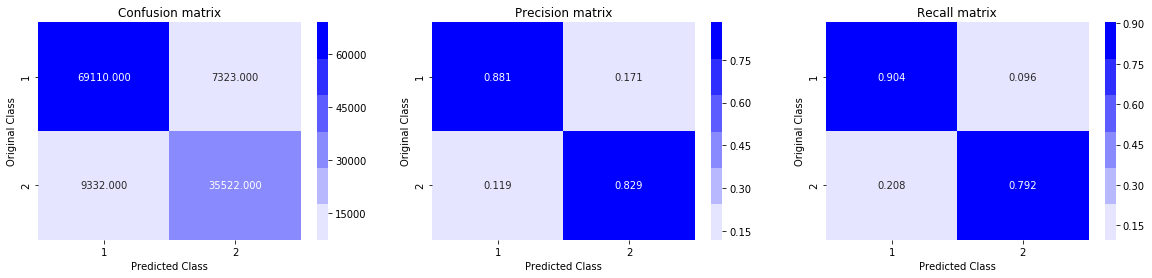

In [63]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

### Conclusion

In [15]:
from prettytable import PrettyTable

x = PrettyTable()


x.field_names = ["MODEL",  "Test Loss"]

x.add_row(['Random Model', '0.885'])
x.add_row(['Logistic Regression', '0.659'])
x.add_row(['Linear SVM', '0.501'])
x.add_row(['XG Boost' ,'0.29335'])

print(x)

+---------------------+-----------+
|        MODEL        | Test Loss |
+---------------------+-----------+
|     Random Model    |   0.885   |
| Logistic Regression |   0.659   |
|      Linear SVM     |   0.501   |
|       XG Boost      |  0.29335  |
+---------------------+-----------+


1. XG Boost is performing extremely well with minimum test loss among all models.
2. the performance of model has improved a lot because of Feature engineering. 